In [1]:
# notebook

# print full np arrays
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# import libraries

import rasterio
import rasterio.plot
from rasterio.crs import CRS
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
import rasterio.mask
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.colors as colors
from matplotlib import cm
from shapely.geometry import Polygon
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint as GCP
import osmnx
from pathlib import Path

from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)

plt.rcParams.update({'font.size': 20})
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from tqdm.auto import tqdm
tqdm.pandas()

from utils import *
from map_utils import *

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set vars here! to define which map is created in which way

region = "europe"
map_path = f"intermediate/map_{region}.tif"

ROADS = False
CITIES = False
SPOTS = False
CIRCLE = 50000 # circle around spot in m for which we assume the waiting time at the spot is definitely relevant
DAY = 24 * 60
WAIT_MAX = DAY
# resolution 40 for world -> 6800x14400 image -> lets calculating distribution crash -> too many values in np array to calculate?

THRESHOLD = 0.00000001 # sum of distributions for at pixel at which we assume we have no data there; quite arbitrary
RECOMPUTE = True # otherwise load from cache if possible

# color the whole map smoothly & fine grained where possible

# approach 1
# adjust stdv of single points
DYNAMIC = False
K = 1
FACTOR_STDV = 1 # the xth stdv

# approach 2
# color not defined areas iteratively by using larger stdvs
ITERATIVE = False
ITERATIONS = 10



In [3]:

def get_points(path):
    points = gpd.read_file(path)
    points.wait = points.wait.astype(float)
    points.lat = points.lat.astype(float)
    points.lon = points.lon.astype(float)
    # threshold - assuming that values above that are skewed due to angriness/ subjectivity of the hiker
    points = points[points['wait'] <= WAIT_MAX]

    # use epsg 3857 as default as it gives coordinates in meters
    points.geometry = gpd.points_from_xy(points.lon, points.lat)
    points.crs = CRS.from_epsg(4326)
    points = points.to_crs(epsg=3857)

    return points
    
# read from the hitchmap dump
points = get_points('../data/points_train.csv')
all_points = points

# to get the same example as here https://abelblogja.wordpress.com/average-waiting-times-in-europe/
artificial_points = get_points("../data/artificial_points.csv")

In [4]:
points, polygon, map = get_points_in_region(points, region)
if region == "artificial": 
        points = artificial_points

In [5]:
# choose larger radius for not dense points (set radius till k other spots are in the radius)
# scaling: https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
def calc_radius(point, other_points, k=5):
    k = k + 1 # +1 as the point itself is also in the array
    distances = point.distance(other_points).to_numpy()
    idx = np.argpartition(distances, k)
    closest_distances = distances[idx[:k]]
    radius = np.ceil(max(closest_distances)) / FACTOR_STDV
    return radius

In [6]:
def make_raster_map(points, polygon, map, iteration=0):
    
    # https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
    def makeGaussian(stdv, x0, y0):
        """Make a square gaussian kernel.
        size is the length of a side of the square
        fwhm is full-width-half-maximum, which
        can be thought of as an effective radius.
        """
        # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
        # TODO why fwhm used here?
        fwhm = 2.355 * stdv

        # gives the distribution in the whole raster space as X and Y are used here
        # TODO only calculate for pixels that will be colored (landmass) in the end
        # TODO only calculate for pixels that are significantly close to the point (e.g. 500 km around the point)
        return np.exp(-4 * np.log(2) * ((X - x0) ** 2 + (Y - y0) ** 2) / fwhm**2)
    
    def get_distribution(lat, lon):
        # standard deviation in meters -> 50 km around each spot; quite arbitrary
        if DYNAMIC: STDV_M = max(CIRCLE, calc_radius(Point(lon, lat), points.geometry, k=K))
        else : STDV_M = CIRCLE + 10000 * iteration
        return makeGaussian(STDV_M, lon, lat)

    # create pixel grid for map
    X, Y = get_map_grid(polygon, map)
    

    # sum of distributions
    Zn = None
    # weighted sum of distributions
    Zn_weighted = None

    try:
        if RECOMPUTE:
            raise Exception("recompute")
        else:
            Z = np.loadtxt(f'intermediate/map_{region}.txt', dtype=float)
            
    except:
        # create a raster map - resulution is defined above
        # https://stackoverflow.com/questions/56677267/tqdm-extract-time-passed-time-remaining
        with tqdm(zip(points.geometry.y, points.geometry.x, points.wait), total=len(points)) as t:
            # TODO find out how to speed up and parallelize this
            for lat, lon, wait in t:
                # distribution inserted by a single point
                Zi = get_distribution(lat, lon)
                # add the new distribution to the sum of existing distributions
                # write them to Zn_weighted and wait every single point/ distribution by the waiting time
                # => it matters where a distribiton is inserted (areas with more distributions have a higher certainty)
                # and which waiting time weight is associated with it
                if Zn is None:
                    Zn = Zi
                    Zn_weighted = Zi * wait
                else:
                    Zn = np.sum([Zn, Zi], axis=0)
                    Zn_weighted = np.sum([Zn_weighted, Zi * wait], axis=0)

            elapsed = t.format_dict['elapsed']
            elapsed_str = t.format_interval(elapsed)
            df = pd.DataFrame({"region": region, 'elapsed time': [elapsed_str]})

            tracker_name = 'logging/time_tracker.csv'
            try:
                full_df = pd.read_csv(tracker_name, index_col=0)
                full_df = pd.concat([full_df, df])
                full_df.to_csv(tracker_name, sep=',')
            except:
                df.to_csv(tracker_name)

        # normalize the weighted sum by the sum of all distributions -> so we see the actual waiting times in the raster
        Z = np.divide(Zn_weighted, Zn, out=np.zeros_like(Zn_weighted), where=Zn!=0)

        # grey out pixels with no hitchhiking spots near them
        undefined = -1.0
        Z = np.where(Zn < THRESHOLD, undefined, Z)
    
        # save the underlying raster data of the heatmap for later use
        np.savetxt(f'intermediate/map_{region}.txt', Z) 

    return X, Y, Z, Zn, Zn_weighted

# set radius of all points +x km and recompute to only color remaining "not-enough-data" pixels
# -> repeat untill full map is colored
if ITERATIVE:
    for i in range(0, ITERATIONS):
        X, Y, Z_raw, Zn, Zn_w = make_raster_map(points, polygon, map, i)

        if i == 0:
            Z = Z_raw
        else:
            Z = np.where(np.logical_and(Z_raw != -1.0, Z == -1.0), Z_raw, Z)

    save_raster(Z, polygon, map)
else:
    X, Y, Z_raw, Zn, Zn_w = make_raster_map(points, polygon, map)
    Z = Z_raw
    save_raster(Z, polygon, map, map_path)

  0%|          | 0/8444 [00:00<?, ?it/s]

100%|██████████| 8444/8444 [02:21<00:00, 59.55it/s]


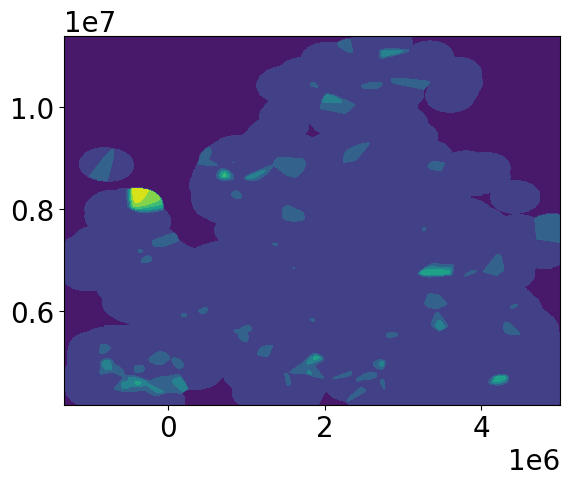

In [7]:
# preview - where the single distributions are placed
p = plt.contourf(X, Y, Z)
plt.show()

In [8]:
states = gpd.read_file("map_features/states/ne_10m_admin_1_states_provinces.shp")
states = states.to_crs(epsg=3857)

# use smaller units for Russia
# country level except for Canada, Russia, USA, Australia, China, Brazil, India, Indonesia
states = states[states.admin != "Antarctica"]

# a state is hitchhikable if there are hitchhiking spots in it
def check_hitchhikability(state):
    points_in_state = points[points.geometry.within(state.geometry)]
    return len(points_in_state) > 0

states["hh"] = states.progress_apply(check_hitchhikability, axis=1)

100%|██████████| 4594/4594 [00:23<00:00, 192.31it/s]


In [9]:
# define the heatmap color scale

# TODO smoother spectrum instead of buckets
buckets = [
    'grey', # not enough data
    '#008200', # dark green
    '#00c800', # light green
    'green', # green
    '#c8ff00', # light yellow
    '#ffff00', # yellow
    '#ffc800', # light orange
    '#ff8200', # dark orange
    'red', # red
    '#c80000', # dark red
    '#820000', # wine red
    'blue', # not necessary to color
    ]

cmap = colors.ListedColormap(buckets)

max_wait = all_points.wait.max() + 0.1 # to get at least this value as maximum for the colored buckets
num_scale_colors = len(buckets) - 2 # because of upper and lower bucket
# build log scale starting at 0 and ending at max wait
base = (max_wait + 1) ** (1/num_scale_colors)

def log_scale(x):
    return base ** x - 1

# how to prevent numerical instabilities resulting in some areas having a checkerboard pattern
# round pixel values to ints
# set the boundaries of the buckets to not be ints
    # should happen automatically through the log scale
    # -0.1 should be 0.0 actually
# boundary of last bucket does not matter - values outside of the range are colored in the last bucket
boundaries = [-1, -0.1] + [log_scale(i) for i in range(1, num_scale_colors+1)] + [max_wait + 1]

# prepare the plot
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
fig, ax = plt.subplots(figsize=(100, 100))


# get borders of all countries
# download https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
# from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
countries = gpd.datasets.get_path("naturalearth_lowres")
countries = gpd.read_file(countries)
countries = countries.to_crs(epsg=3857)
countries = countries[countries.name != "Antarctica"]
# TODO so far does not work as in final map the raster is not applied to the whole region
# countries = countries[countries.geometry.within(polygon.geometry[0])]
country_shapes = countries.geometry
countries.plot(ax=ax, facecolor='none', edgecolor='black')

# TODO takes more time than expected
# use a pre-compiled list of important cities
# download https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_populated_places.zip
# from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
# cities = gpd.read_file("cities/ne_10m_populated_places.shp", bbox=polygon.geometry[0]) should work but does not
if CITIES:
    cities = gpd.read_file("map_features/cities/ne_10m_populated_places.shp") # takes most time
    cities = cities.to_crs(epsg=3857)
    cities = cities[cities.geometry.within(polygon.geometry[0])]
    cities.plot(ax=ax, markersize=1, color='black')

# use a pre-compiles list of important roads
# download https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_roads.zip
# from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
if ROADS:
    roads = gpd.read_file("roads/ne_10m_roads.shp")
    roads = roads.to_crs(epsg=3857)
    roads = roads[roads.geometry.within(polygon.geometry[0])]
    roads.plot(ax=ax, markersize=1, color='black')

if SPOTS: all_points.plot(ax=ax, markersize=10, color='red')

# limit heatmap to landmass by asigning inf/ high value to sea
with rasterio.open(map_path) as heatmap:
    out_image, out_transform = rasterio.mask.mask(heatmap, country_shapes, crop=True, filled=False)
    out_meta = heatmap.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(map_path, "w", **out_meta) as destination:
    destination.write(out_image)


# plot the heatmap
raster = rasterio.open(map_path)
rasterio.plot.show(raster, ax=ax, cmap=cmap, norm=norm)

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
if ITERATIVE: file_name = f"maps/map_{region}_iter_{ITERATIONS}.png"
elif DYNAMIC: file_name = f"maps/map_{region}_{K}.png"
else: file_name = f"maps/map_{region}.png"
plt.savefig(file_name, bbox_inches='tight')

/tmp/ipykernel_3434935/2431424740.py:45: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


In [10]:
# from https://rasterio.readthedocs.io/en/stable/quickstart.html#spatial-indexing
def map_predict(lon, lat, raster):
    # transform the lat/lon to the raster's CRS
    x, y = raster.index(lon, lat)
    # read the raster at the given coordinates
    return raster.read(1)[x, y]

# eval

In [11]:
val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)

val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

# X = val[['lat', 'lon']].values
val['pred'] = val.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

# for val points in the sea or on islands the model does not provide valid predictions
no_data = 1e20 # ocean area
val = val[val['pred'] != no_data]

(mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred']))

100%|██████████| 2786/2786 [00:00<00:00, 6413.53it/s]


(3709.7484165491296, 60.907704082071014, 30.27673135871115)

In [12]:
# germany (2017.0828210097397, 44.91194519289651, 26.35369707811568)
# europe 